# 今回の取り組み

- `extract_mutation_loci`のメモリ処理をリアルデータでプロファイリングします
    - リアルデータはR10.4、BSA添加なしのBC01とBC32です

## いつものセットアップ

In [16]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)

print(os.getcwd())
sys.path.append(os.getcwd() + "/" + "src")

/mnt/d/Research/DAJIN2


In [2]:
%%bash
pip uninstall -qy DAJIN2
# pipの更新
# pip install -q -U pip
# pip install -q -U -r requirements.txt

# 実験

- `preprocessing`まででexitするようにしたコードで前処理だけを行います

In [5]:
%%bash
pip install -qe .
time DAJIN2 \
    --name single-r10 \
    --sample "misc/data/r10_barcode01.fq.gz" \
    --control "misc/data/r10_barcode32.fq.gz" \
    --allele "misc/data/tyr_control.fasta" \
    --genome mm10 \
    --threads 10

misc/data/r10_barcode32.fq.gz is now processing...
misc/data/r10_barcode32.fq.gz: midsv_control_alleles is 232
misc/data/r10_barcode32.fq.gz is finished...
misc/data/r10_barcode01.fq.gz is now processing...
2023-05-03 05:53:32: Preprocess r10_barcode01...
2023-05-03 05:53:32: mapping r10_barcode01...
2023-05-03 05:55:57: midsv r10_barcode01...
2023-05-03 05:57:08: extract_mutation_loci r10_barcode01...
2023-05-03 05:57:50: correct_sequence_error r10_barcode01...
r10_barcode01 is finished by correct_sequence_error.



real	12m9.177s
user	11m39.292s
sys	0m8.367s


- とりあえずはエラーがなく終わりました
    - `extract_mutation_loci `はメモリ消費量も比較的低めだったように思います
    - `correct_sequence_error `はメモリバク食いでした。10GB以上消費していました。

In [6]:
%%bash

ls -lht DAJINResults/.tempdir/single-r10/midsv
ls -lht DAJINResults/.tempdir/single-r10/mutation_loci

total 1.1G
-rwxrwxrwx 1 kuno kuno 604M May  3 05:57 r10_barcode01.plk
-rwxrwxrwx 1 kuno kuno 512M May  3 05:53 r10_barcode32.plk
total 2.0M
-rwxrwxrwx 1 kuno kuno 5.7K May  3 05:57 r10_barcode01.plk


In [9]:
import pickle
allele = "control"
sample = "DAJINResults/.tempdir/single-r10/midsv/r10_barcode01.plk"
with open(sample, "rb") as p:
    midsv_sample_alleles = pickle.load(p)
midsv_sample = dict()
midsv_sample = midsv_sample_alleles[allele][:10]

In [11]:
print(len(midsv_sample))
print(midsv_sample)

10
[{'QNAME': '000166d7-3ce7-432f-bc05-56757c17fcb5', 'CSSPLIT': '=T,=G,=C,=A,=T,=T,=G,=A,=A,=G,=C,+A|=A,=G,*TC,*TC,=C,=A,-C,=C,*AT,=A,=A,=A,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=G,=A,=T,=A,=T,=C,=T,=T,=T,=G,=G,=A,=A,=T,=A,=A,=T,=C,=A,=A,=T,=T,-C,=A,=A,=G,=A,=T,=A,=A,=T,=C,=A,=A,=G,=G,=A,=A,=A,=A,=A,=T,=G,=A,=G,=A,=G,=G,-C,=A,=A,=C,*TG,=A,-T,-T,=T,*TC,=A,=G,=A,=C,=T,*GC,=A,=T,=T,=A,=C,=T,=T,=T,=T,=A,=T,=A,=A,=A,=A,-T,=A,*AG,=A,*TC,=A,=A,=G,=C,=T,=C,+A|+A|=A,=G,=C,-T,=T,=A,=G,=C,=C,=A,=G,=A,=T,=A,=T,=A,=A,=G,=C,=A,=A,=T,=A,=T,=T,=C,=T,=G,=A,=G,=T,=T,=C,=T,=G,=A,=A,=G,-A,=A,=A,=A,=A,=T,=T,=T,=T,=T,=G,=A,=C,=A,=A,=A,=A,=T,=G,=A,=G,=T,=T,=C,=T,=A,=T,=A,=A,=A,=T,=G,=T,*TC,=A,=T,=T,=G,=T,-C,=T,=A,=C,-T,=T,=A,=T,*GT,=A,=T,=C,=T,-C,*TA,=A,=A,=A,=T,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=T,=G,=T,=A,=T,=T,=C,=A,=G,=A,=A,=T,=C,=T,=A,=G,=A,=T,=G,=T,=T,*TC,=C,=A,=T,=G,=A,=C,=C,=T,=T,=T,=A,=T,=T,=C,=A,=T,=A,=A,=G,=A,=G,=A,=T,=G,=A,=T,=G,=T,=A,=T,=T,=C,=T,*TC,*GT,=A,=T,=A,=C,=T,=A,=C,=T,=T

- メモリプロファイルを試みます

In [85]:
%%writefile tmp_memory_profile.py
from __future__ import annotations
from memory_profiler import profile

import os
# prevent BLAS from using all cores
os.environ['OMP_NUM_THREADS'] = "1"
os.environ['OPENBLAS_NUM_THREADS'] = "1"
os.environ['MKL_NUM_THREADS'] = "1"
os.environ['VECLIB_MAXIMUM_THREADS'] = "1"
os.environ['NUMEXPR_NUM_THREADS'] = "1"


import re
from collections import defaultdict

import numpy as np
from scipy import stats
from scipy.spatial import distance
from sklearn.neighbors import LocalOutlierFactor
from typing import Generator


def _count_indels(midsv_sample, len_sequence: int) -> dict[str, list[int]]:
    count = {"+": [0] * len_sequence,
            "-": [0] * len_sequence,
            "*": [0] * len_sequence}
    for samp in midsv_sample:
        for i, cs in enumerate(samp["CSSPLIT"].split(",")):
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                # count["+"][i] += len(cs.split("|"))
                count["+"][i] += 1
            elif cs.startswith("-"):
                count["-"][i] += 1
            elif cs.startswith("*"):
                count["*"][i] += 1
    return count


def _split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
    results = defaultdict(list)
    center = kmer // 2
    for mut, value in indels.items():
        for i in range(len(value)):
            if center <= i <= len(value) - center:
                start = i - center
                if kmer % 2 == 0:
                    end = i + center
                else:
                    end = i + center + 1
                results[mut].append(value[start : end])
            else:
                results[mut].append([0]*kmer)
    return results


def _extract_anomaly_loci(indels_kmer_sample: dict, indels_kmer_control: dict, coverage_sample: int, coverage_control: int) -> dict[str, set[int]]:
    anomaly_loci = dict()
    clf = LocalOutlierFactor(novelty=True, n_neighbors=5)
    for key in indels_kmer_sample.keys():
        loci = set()
        values_control = np.array(indels_kmer_control[key]) / coverage_control
        values_sample = np.array(indels_kmer_sample[key]) / coverage_sample
        index = -1
        for i, (value_control, value_sample) in enumerate(zip(values_control, values_sample)):
            if i == index:
                continue
            clf.fit(value_control.reshape(-1, 1))
            pred = clf.predict(value_sample.reshape(-1, 1))
            if pred[5] == -1:
                loci.add(i)
            # If the next base is not -1, do not validate the next base because the next base is not an outlier.
            if pred[6] == 1:
                index = i + 1
        anomaly_loci.update({key: loci})
    return anomaly_loci


def _extract_dissimilar_loci(indels_kmer_sample: dict[str, list[list[int]]], indels_kmer_control: dict[str, list[list[int]]]) -> dict[str, set]:
    results = dict()
    for mut in indels_kmer_sample:
        cossim = [distance.cosine(x, y) for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        pvalues = [stats.ttest_ind(x, y, equal_var=False)[1] for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        # if pvalue == nan, samples and controls are exactly same.
        cossim_pval_false = [cossim if pvalue > 0.05 or np.isnan(pvalue) else 1 for cossim, pvalue in zip(cossim, pvalues)]
        dissimilar_loci = {i for i, x in enumerate(cossim_pval_false) if x > 0.05}
        results.update({mut: dissimilar_loci})
    return results


def _transpose_mutation_loci(mutation_loci, len_sequence):
    mutation_loci_transposed = [set() for _ in range(len_sequence)]
    for mut, idx_mutation in mutation_loci.items():
        for i, loci in enumerate(mutation_loci_transposed):
            if i in idx_mutation:
                loci.add(mut)
    return mutation_loci_transposed

###########################################################
# main
###########################################################

@profile
def extract_mutation_loci(midsv_sample_alleles, midsv_control_alleles) -> dict[str, list[set[str]]]:
    allele = "control"
    midsv_sample = midsv_sample_alleles[allele]
    midsv_control = midsv_control_alleles[allele]
    len_sequence = len(midsv_sample_alleles[allele][0]["CSSPLIT"].split(","))
    indels_sample = _count_indels(midsv_sample, len_sequence)
    indels_control = _count_indels(midsv_control, len_sequence)
    indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
    indels_kmer_control = _split_kmer(indels_control, kmer = 10)
    anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, len(midsv_sample), len(midsv_control))
    dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
    mutation_loci = dict()
    for mut in anomaly_loci:
        mutation_loci.update({mut: anomaly_loci[mut] & dissimilar_loci[mut]})
    mutation_loci_transposed = _transpose_mutation_loci(mutation_loci, len_sequence)
    return mutation_loci_transposed

import pickle

def prepare_samples():
    sample = "DAJINResults/.tempdir/single-r10/midsv/r10_barcode01.plk"
    control = "DAJINResults/.tempdir/single-r10/midsv/r10_barcode32.plk"
    with open(sample, "rb") as p:
        midsv_sample_alleles = pickle.load(p)
    with open(control, "rb") as p:
        midsv_control_alleles = pickle.load(p)
    midsv_sample = dict()
    midsv_control = dict()
    midsv_sample["control"] = midsv_sample_alleles["control"] #[:1000]
    midsv_control["control"] = midsv_control_alleles["control"] #[:1000]
    del midsv_sample_alleles
    del midsv_control_alleles
    return midsv_sample, midsv_control

if __name__ == '__main__':
    # 引数
    midsv_sample, midsv_control = prepare_samples()
    print(f"Read number: {len(midsv_control['control'])}")
    print("execute...")
    extract_mutation_loci(midsv_sample, midsv_control)



Overwriting tmp_memory_profile.py


In [86]:
%%bash
mprof run tmp_memory_profile.py

mprof: Sampling memory every 0.1s
running new process
running as a Python program...
Read number: 62730
execute...


/home/kuno/miniconda/lib/python3.10/site-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


Filename: tmp_memory_profile.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   104   1279.5 MiB   1279.5 MiB           1   @profile
   105                                         def extract_mutation_loci(midsv_sample_alleles, midsv_control_alleles) -> dict[str, list[set[str]]]:
   106   1279.5 MiB      0.0 MiB           1       allele = "control"
   107   1279.5 MiB      0.0 MiB           1       midsv_sample = midsv_sample_alleles[allele]
   108   1279.5 MiB      0.0 MiB           1       midsv_control = midsv_control_alleles[allele]
   109   1279.5 MiB      0.0 MiB           1       len_sequence = len(midsv_sample_alleles[allele][0]["CSSPLIT"].split(","))
   110   1279.8 MiB      0.3 MiB           1       indels_sample = _count_indels(midsv_sample, len_sequence)
   111   1280.0 MiB      0.3 MiB           1       indels_control = _count_indels(midsv_control, len_sequence)
   112   1281.1 MiB      1.0 MiB           1       indels_kmer_sample = _split_kmer(indels_sam

In [89]:
! mprof plot -o tmp_image.png --backend agg

Using last profile data.


- `tmp_image.png`

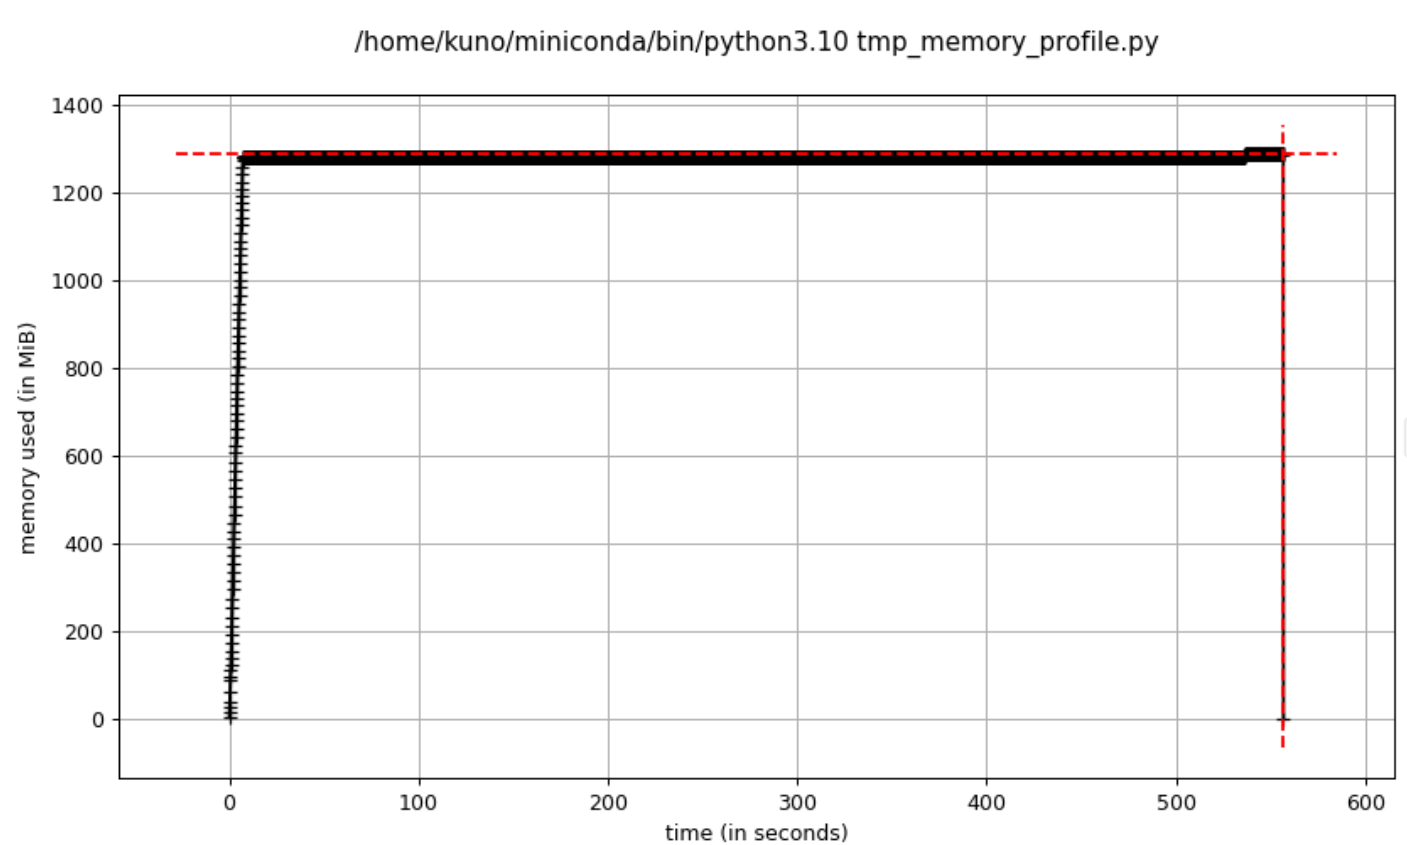

- `extract_mutation_loci`自体はほとんどメモリを消費していませんでした
- `pickle`オブジェクトのロード（`midsv_sample_alleles`などのオブジェクト）で1.2GBほどのデータ量になりました
    - `pickle`オブジェクトを削除してもメモリは残っているようです
    - `pickle`ではなくて、JSONで一行ずつ読み込ませたほうが良さそうです
    - `midsv_sample_alleles`の出力をやめて、ファイルとして出力します

In [77]:
import json
import gzip
data = [{"hoge": "fuga", "foo": 3}, {"xxx": "yyy", "zzz": 101}]
filename = "tmp.json"
with gzip.open(filename, 'wt', encoding="ascii") as gz:
    for d in data:
        gz.write(json.dumps(d) + "\n")
    # json.dump(data, gz)

In [78]:
%%bash
file tmp.json.gz
zcat tmp.json.gz
cat tmp.jsonl

tmp.json.gz: gzip compressed data, was "tmp.json", last modified: Tue May  2 21:37:56 2023, max compression, original size modulo 2^32 54
{"hoge": "fuga", "foo": 3}
{"xxx": "yyy", "zzz": 101}
{"hoge": "fuga", "foo": 3}
{"xxx": "yyy", "zzz": 101}


In [73]:
# with gzip.open(filename, 'r') as f:
#     for obj in json.loads(f):
#         print(obj)
with gzip.open(filename, 'r') as f:
    for line in f:
        obj = json.loads(line)
        print(obj)

{'hoge': 'fuga', 'foo': 3}
{'xxx': 'yyy', 'zzz': 101}


- generatorをdumpできるのか？

In [88]:
import json
import gzip

def generate_data():
    for i in range(3):
        yield {"hoge": "fuga", "foo": i}

# data = [{"hoge": "fuga", "foo": 3}, {"xxx": "yyy", "zzz": 101}]
data = generate_data()
filename = "tmp.json.gz"
with gzip.open(filename, 'wt', encoding="ascii") as gz:
    for d in data:
        gz.write(json.dumps(d) + "\n")
    # json.dump(data, gz)

- 大丈夫そうです

In [104]:
def count_newlines(filepath):
    def _make_gen(reader):
        while True:
            b = reader(2 ** 16)
            if not b: break
            yield b

    with open(filepath, "rb") as f:
        count = sum(buf.count(b"\n") for buf in _make_gen(f.raw.read))
    return count

In [105]:
def countlines(filepath):
    count = 0
    with open(filepath, 'rb') as file:
        while 1:
            buffer = file.read(8192*1024)
            if not buffer: break
            count += buffer.count('\n')
    return count

In [116]:
import json
data = [{"hoge": "fuga", "foo": 3}] * 100_000_000
filename = "tmp.json"
with open(filename, 'wt', encoding="ascii") as gz:
    for d in data:
        gz.write(json.dumps(d) + "\n")

KeyboardInterrupt: 

In [ ]:
%%bash
ls -lht tmp.json
wc -l tmp.json

-rwxrwxrwx 1 kuno kuno 26M May  3 07:24 tmp.json
1000000 tmp.json


In [ ]:
filepath = "DAJINResults/.tempdir/single-r10/midsv/r10_barcode32_control.json"
def count_newlines(filepath):
    def _make_gen(reader):
        while True:
            b = reader(2 ** 16)
            if not b: break
            yield b
    with open(filepath, "rb") as f:
        count = sum(buf.count(b"\n") for buf in _make_gen(f.raw.read))
    return count

print(count_newlines(filepath))

1000000


- `call_midsv`の結果を`json`に保存しました
    - `extract_mutation_loci`までいちど実行します

In [141]:
%%bash
rm -rf DAJINResults/single-r10
rm -rf DAJINResults/.tempdir/single-r10

pip install -qe .
time DAJIN2 \
    --name single-r10 \
    --sample "misc/data/r10_barcode31.fq.gz" \
    --control "misc/data/r10_barcode32.fq.gz" \
    --allele "misc/data/tyr_control.fasta" \
    --genome mm10 \
    --threads 10

misc/data/r10_barcode32.fq.gz is now processing...
2023-05-03 07:52:50: Preprocess r10_barcode32...
2023-05-03 07:52:50: Mapping r10_barcode32...
2023-05-03 07:54:56: Call MIDSV r10_barcode32...
misc/data/r10_barcode32.fq.gz is finished!
misc/data/r10_barcode31.fq.gz is now processing...
2023-05-03 07:56:25: Preprocess r10_barcode31...
2023-05-03 07:56:25: Mapping r10_barcode31...
2023-05-03 07:57:15: midsv r10_barcode31...
2023-05-03 07:57:40: extract_mutation_loci r10_barcode31...



real	6m1.968s
user	5m5.138s
sys	0m5.842s


In [144]:
from __future__ import annotations
from pathlib import Path

from src.DAJIN2.core import preprocess, classification, clustering, consensus, report

#### # * Subset of Point mutation
#### # 50 or 10 or 01%
percent = "50"
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "misc/data/r10_barcode31.fq.gz",
    "misc/data/r10_barcode32.fq.gz",
    "misc/data/tyr_control.fasta",
    "single-r10",
    "mm10",
    True,
    30,
)


######################################################################
# Preprocessing
######################################################################

print(f"processing {NAME}...")

# ====================================================================
# Varidate inputs
# ====================================================================

preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

# ====================================================================
# Format inputs
# ====================================================================
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = preprocess.format_inputs.update_threads(THREADS)

SUBDIRS = ["cache", "fasta", "sam", "midsv", "report", "result", "mutation_loci"]
preprocess.format_inputs.make_directories(TEMPDIR, SUBDIRS, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


processing single-r10...


In [146]:
print(TEMPDIR, SAMPLE_NAME)

DAJINResults/.tempdir/single-r10 r10_barcode31


In [148]:
from __future__ import annotations

import re
from collections import defaultdict
import json
import numpy as np
from pathlib import Path
from typing import Generator
from scipy import stats
from scipy.spatial import distance
from sklearn.neighbors import LocalOutlierFactor


def _count_indels(midsv_sample, len_sequence: int) -> dict[str, list[int]]:
    count = {"+": [0] * len_sequence,
            "-": [0] * len_sequence,
            "*": [0] * len_sequence}
    for samp in midsv_sample:
        for i, cs in enumerate(samp["CSSPLIT"].split(",")):
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                # count["+"][i] += len(cs.split("|"))
                count["+"][i] += 1
            elif cs.startswith("-"):
                count["-"][i] += 1
            elif cs.startswith("*"):
                count["*"][i] += 1
    return count


def _split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
    results = defaultdict(list)
    center = kmer // 2
    for mut, value in indels.items():
        for i in range(len(value)):
            if center <= i <= len(value) - center:
                start = i - center
                if kmer % 2 == 0:
                    end = i + center
                else:
                    end = i + center + 1
                results[mut].append(value[start : end])
            else:
                results[mut].append([0]*kmer)
    return results


def _extract_anomaly_loci(indels_kmer_sample: dict, indels_kmer_control: dict, coverage_sample: int, coverage_control: int) -> dict[str, set[int]]:
    anomaly_loci = dict()
    clf = LocalOutlierFactor(novelty=True, n_neighbors=5)
    for key in indels_kmer_sample.keys():
        loci = set()
        values_control = np.array(indels_kmer_control[key]) / coverage_control
        values_sample = np.array(indels_kmer_sample[key]) / coverage_sample
        index = -1
        for i, (value_control, value_sample) in enumerate(zip(values_control, values_sample)):
            if i == index:
                continue
            clf.fit(value_control.reshape(-1, 1))
            pred = clf.predict(value_sample.reshape(-1, 1))
            if pred[5] == -1:
                loci.add(i)
            # If the next base is not -1, do not validate the next base because the next base is not an outlier.
            if pred[6] == 1:
                index = i + 1
        anomaly_loci.update({key: loci})
    return anomaly_loci


def _extract_dissimilar_loci(indels_kmer_sample: dict[str, list[list[int]]], indels_kmer_control: dict[str, list[list[int]]]) -> dict[str, set]:
    results = dict()
    for mut in indels_kmer_sample:
        cossim = [distance.cosine(x, y) for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        pvalues = [stats.ttest_ind(x, y, equal_var=False)[1] for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        # if pvalue == nan, samples and controls are exactly same.
        cossim_pval_false = [cossim if pvalue > 0.05 or np.isnan(pvalue) else 1 for cossim, pvalue in zip(cossim, pvalues)]
        dissimilar_loci = {i for i, x in enumerate(cossim_pval_false) if x > 0.05}
        results.update({mut: dissimilar_loci})
    return results


def _transpose_mutation_loci(mutation_loci, len_sequence):
    mutation_loci_transposed = [set() for _ in range(len_sequence)]
    for mut, idx_mutation in mutation_loci.items():
        for i, loci in enumerate(mutation_loci_transposed):
            if i in idx_mutation:
                loci.add(mut)
    return mutation_loci_transposed

###########################################################
# main
###########################################################

def read_midsv(filepath) -> Generator[dict[str, str]]:
    with open(filepath, 'r') as f:
        for line in f:
            yield json.loads(line)


def count_newlines(filepath):
    def _make_gen(reader):
        while True:
            b = reader(2 ** 16)
            if not b: break
            yield b
    with open(filepath, "rb") as f:
        count = sum(buf.count(b"\n") for buf in _make_gen(f.raw.read))
    return count

def extract_mutation_loci(TEMPDIR: Path, FASTA_ALLELES: dict, SAMPLE_NAME: str, CONTROL_NAME:str) -> dict[str, list[set[str]]]:
    MUTATION_LOCI_ALLELES = dict()
    for allele, sequence in FASTA_ALLELES.items():
        filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
        filepath_control = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json")
        covarage_sample = count_newlines(filepath_sample)
        covarage_control = count_newlines(filepath_control)
        indels_sample = _count_indels(read_midsv(filepath_sample), len(sequence))
        indels_control = _count_indels(read_midsv(filepath_control), len(sequence))
        indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
        indels_kmer_control = _split_kmer(indels_control, kmer = 10)
        anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, covarage_sample, covarage_control)
        dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
        mutation_loci = dict()
        for mut in anomaly_loci:
            mutation_loci.update({mut: anomaly_loci[mut] & dissimilar_loci[mut]})
        mutation_loci_transposed = _transpose_mutation_loci(mutation_loci, len(sequence))
        MUTATION_LOCI_ALLELES.update({allele: mutation_loci_transposed})
    return MUTATION_LOCI_ALLELES


In [149]:
MUTATION_LOCI_ALLELES = extract_mutation_loci(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME)

In [ ]:
print(len(MUTATION_LOCI_ALLELES[allele]))
print(MUTATION_LOCI_ALLELES[allele][828])

2845
{'*', '-'}


- jsonに直したところで、再びメモリプロファイルをします

In [157]:
%%writefile tmp_memory_profile.py
from __future__ import annotations
from memory_profiler import profile

###########################################################################
import re
from collections import defaultdict
import json
import numpy as np
from pathlib import Path
from typing import Generator
from scipy import stats
from scipy.spatial import distance
from sklearn.neighbors import LocalOutlierFactor


def _count_indels(midsv_sample, len_sequence: int) -> dict[str, list[int]]:
    count = {"+": [0] * len_sequence,
            "-": [0] * len_sequence,
            "*": [0] * len_sequence}
    for samp in midsv_sample:
        for i, cs in enumerate(samp["CSSPLIT"].split(",")):
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                # count["+"][i] += len(cs.split("|"))
                count["+"][i] += 1
            elif cs.startswith("-"):
                count["-"][i] += 1
            elif cs.startswith("*"):
                count["*"][i] += 1
    return count


def _split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
    results = defaultdict(list)
    center = kmer // 2
    for mut, value in indels.items():
        for i in range(len(value)):
            if center <= i <= len(value) - center:
                start = i - center
                if kmer % 2 == 0:
                    end = i + center
                else:
                    end = i + center + 1
                results[mut].append(value[start : end])
            else:
                results[mut].append([0]*kmer)
    return results


def _extract_anomaly_loci(indels_kmer_sample: dict, indels_kmer_control: dict, coverage_sample: int, coverage_control: int) -> dict[str, set[int]]:
    anomaly_loci = dict()
    clf = LocalOutlierFactor(novelty=True, n_neighbors=5)
    for key in indels_kmer_sample.keys():
        loci = set()
        values_control = np.array(indels_kmer_control[key]) / coverage_control
        values_sample = np.array(indels_kmer_sample[key]) / coverage_sample
        index = -1
        for i, (value_control, value_sample) in enumerate(zip(values_control, values_sample)):
            if i == index:
                continue
            clf.fit(value_control.reshape(-1, 1))
            pred = clf.predict(value_sample.reshape(-1, 1))
            if pred[5] == -1:
                loci.add(i)
            # If the next base is not -1, do not validate the next base because the next base is not an outlier.
            if pred[6] == 1:
                index = i + 1
        anomaly_loci.update({key: loci})
    return anomaly_loci


def _extract_dissimilar_loci(indels_kmer_sample: dict[str, list[list[int]]], indels_kmer_control: dict[str, list[list[int]]]) -> dict[str, set]:
    results = dict()
    for mut in indels_kmer_sample:
        cossim = [distance.cosine(x, y) for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        pvalues = [stats.ttest_ind(x, y, equal_var=False)[1] for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        # if pvalue == nan, samples and controls are exactly same.
        cossim_pval_false = [cossim if pvalue > 0.05 or np.isnan(pvalue) else 1 for cossim, pvalue in zip(cossim, pvalues)]
        dissimilar_loci = {i for i, x in enumerate(cossim_pval_false) if x > 0.05}
        results.update({mut: dissimilar_loci})
    return results


def _transpose_mutation_loci(mutation_loci, len_sequence):
    mutation_loci_transposed = [set() for _ in range(len_sequence)]
    for mut, idx_mutation in mutation_loci.items():
        for i, loci in enumerate(mutation_loci_transposed):
            if i in idx_mutation:
                loci.add(mut)
    return mutation_loci_transposed

###########################################################
# main
###########################################################

def read_midsv(filepath) -> Generator[dict[str, str]]:
    with open(filepath, 'r') as f:
        for line in f:
            yield json.loads(line)


def count_newlines(filepath):
    def _make_gen(reader):
        while True:
            b = reader(2 ** 16)
            if not b: break
            yield b
    with open(filepath, "rb") as f:
        count = sum(buf.count(b"\n") for buf in _make_gen(f.raw.read))
    return count

@profile
def extract_mutation_loci(TEMPDIR: Path, FASTA_ALLELES: dict, SAMPLE_NAME: str, CONTROL_NAME:str) -> dict[str, list[set[str]]]:
    MUTATION_LOCI_ALLELES = dict()
    for allele, sequence in FASTA_ALLELES.items():
        filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
        filepath_control = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json")
        covarage_sample = count_newlines(filepath_sample)
        covarage_control = count_newlines(filepath_control)
        indels_sample = _count_indels(read_midsv(filepath_sample), len(sequence))
        indels_control = _count_indels(read_midsv(filepath_control), len(sequence))
        indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
        indels_kmer_control = _split_kmer(indels_control, kmer = 10)
        anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, covarage_sample, covarage_control)
        dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
        mutation_loci = dict()
        for mut in anomaly_loci:
            mutation_loci.update({mut: anomaly_loci[mut] & dissimilar_loci[mut]})
        mutation_loci_transposed = _transpose_mutation_loci(mutation_loci, len(sequence))
        MUTATION_LOCI_ALLELES.update({allele: mutation_loci_transposed})
    return MUTATION_LOCI_ALLELES

#####################################################################################
# import pickle

# def prepare_samples():
#     sample = "DAJINResults/.tempdir/single-r10/midsv/r10_barcode01.plk"
#     control = "DAJINResults/.tempdir/single-r10/midsv/r10_barcode32.plk"
#     with open(sample, "rb") as p:
#         midsv_sample_alleles = pickle.load(p)
#     with open(control, "rb") as p:
#         midsv_control_alleles = pickle.load(p)
#     midsv_sample = dict()
#     midsv_control = dict()
#     midsv_sample["control"] = midsv_sample_alleles["control"] #[:1000]
#     midsv_control["control"] = midsv_control_alleles["control"] #[:1000]
#     del midsv_sample_alleles
#     del midsv_control_alleles
#     return midsv_sample, midsv_control

if __name__ == '__main__':
    # 引数
    from DAJIN2.core import (classification, clustering, consensus, preprocess, report)
    SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
        "misc/data/r10_barcode31.fq.gz",
        "misc/data/r10_barcode32.fq.gz",
        "misc/data/tyr_control.fasta",
        "single-r10",
        "mm10",
        True,
        30,
    )

    TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
    SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
    CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
    FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
    # midsv_sample, midsv_control = prepare_samples()
    # print(f"Read number: {len(midsv_control['control'])}")
    print("execute...")
    MUTATION_LOCI_ALLELES = extract_mutation_loci(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME)


Overwriting tmp_memory_profile.py


In [158]:
%%bash
mprof run tmp_memory_profile.py

mprof: Sampling memory every 0.1s
running new process
running as a Python program...
execute...


In [159]:
! mprof plot -o tmp_image.png --backend agg

Using last profile data.


- 期待した通り、`250MB`まで下がりました！
  - とは言え、本音ではほぼメモリを消費しないのが理想なのですが。。。
  - 一瞬で`250MB`まで上がっているので、どこかでファイルを一括で読み込んでいるみたいです？

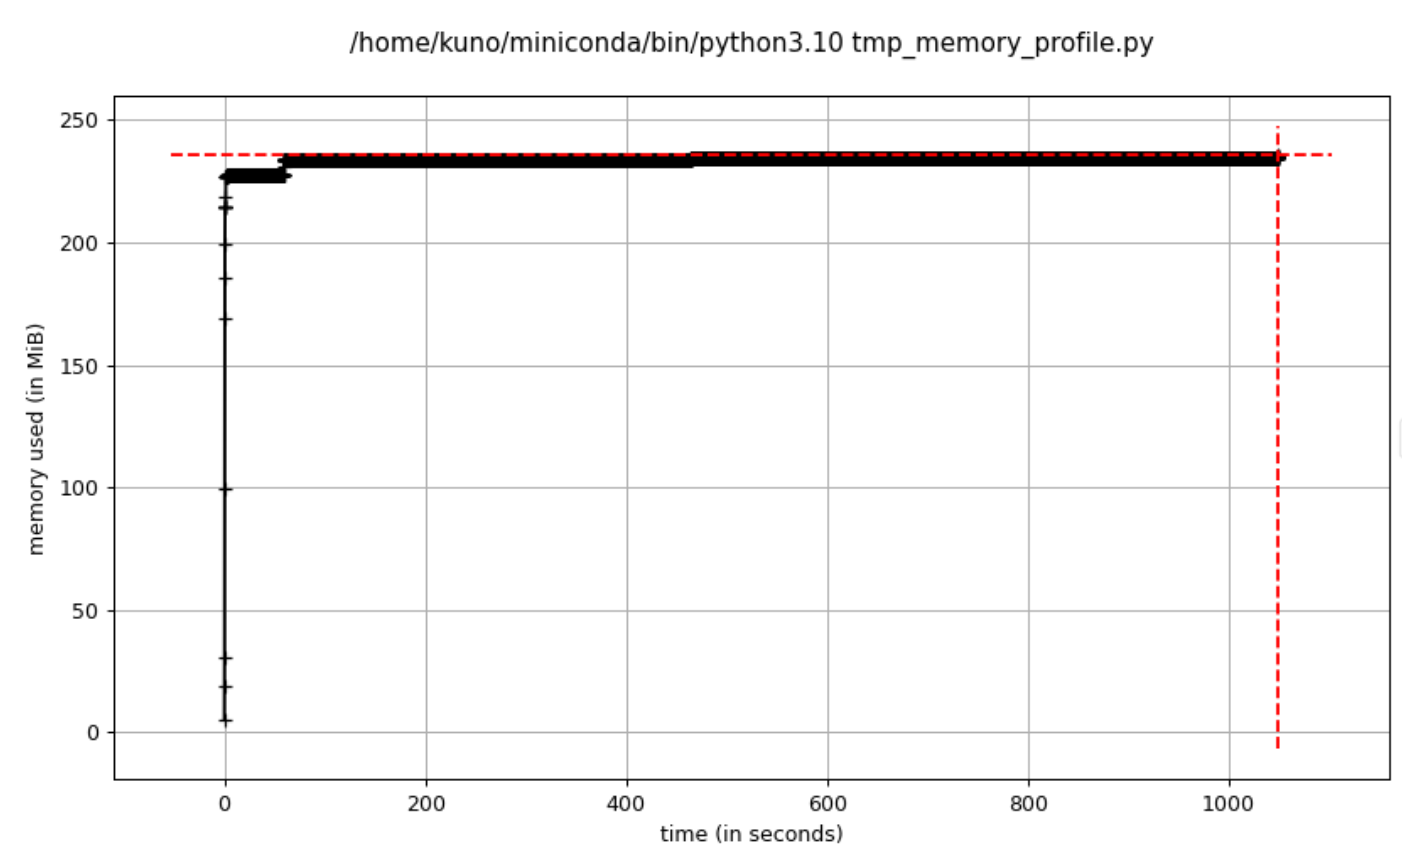


In [161]:
%%writefile tmp_memory_profile.py
from __future__ import annotations
from memory_profiler import profile

###########################################################################
import re
from collections import defaultdict
import json
import numpy as np
from pathlib import Path
from typing import Generator
from scipy import stats
from scipy.spatial import distance
from sklearn.neighbors import LocalOutlierFactor


def _count_indels(midsv_sample, len_sequence: int) -> dict[str, list[int]]:
    count = {"+": [0] * len_sequence,
            "-": [0] * len_sequence,
            "*": [0] * len_sequence}
    for samp in midsv_sample:
        for i, cs in enumerate(samp["CSSPLIT"].split(",")):
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                # count["+"][i] += len(cs.split("|"))
                count["+"][i] += 1
            elif cs.startswith("-"):
                count["-"][i] += 1
            elif cs.startswith("*"):
                count["*"][i] += 1
    return count


def _split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
    results = defaultdict(list)
    center = kmer // 2
    for mut, value in indels.items():
        for i in range(len(value)):
            if center <= i <= len(value) - center:
                start = i - center
                if kmer % 2 == 0:
                    end = i + center
                else:
                    end = i + center + 1
                results[mut].append(value[start : end])
            else:
                results[mut].append([0]*kmer)
    return results


def _extract_anomaly_loci(indels_kmer_sample: dict, indels_kmer_control: dict, coverage_sample: int, coverage_control: int) -> dict[str, set[int]]:
    anomaly_loci = dict()
    clf = LocalOutlierFactor(novelty=True, n_neighbors=5)
    for key in indels_kmer_sample.keys():
        loci = set()
        values_control = np.array(indels_kmer_control[key]) / coverage_control
        values_sample = np.array(indels_kmer_sample[key]) / coverage_sample
        index = -1
        for i, (value_control, value_sample) in enumerate(zip(values_control, values_sample)):
            if i == index:
                continue
            clf.fit(value_control.reshape(-1, 1))
            pred = clf.predict(value_sample.reshape(-1, 1))
            if pred[5] == -1:
                loci.add(i)
            # If the next base is not -1, do not validate the next base because the next base is not an outlier.
            if pred[6] == 1:
                index = i + 1
        anomaly_loci.update({key: loci})
    return anomaly_loci


def _extract_dissimilar_loci(indels_kmer_sample: dict[str, list[list[int]]], indels_kmer_control: dict[str, list[list[int]]]) -> dict[str, set]:
    results = dict()
    for mut in indels_kmer_sample:
        cossim = [distance.cosine(x, y) for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        pvalues = [stats.ttest_ind(x, y, equal_var=False)[1] for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        # if pvalue == nan, samples and controls are exactly same.
        cossim_pval_false = [cossim if pvalue > 0.05 or np.isnan(pvalue) else 1 for cossim, pvalue in zip(cossim, pvalues)]
        dissimilar_loci = {i for i, x in enumerate(cossim_pval_false) if x > 0.05}
        results.update({mut: dissimilar_loci})
    return results


def _transpose_mutation_loci(mutation_loci, len_sequence):
    mutation_loci_transposed = [set() for _ in range(len_sequence)]
    for mut, idx_mutation in mutation_loci.items():
        for i, loci in enumerate(mutation_loci_transposed):
            if i in idx_mutation:
                loci.add(mut)
    return mutation_loci_transposed

###########################################################
# main
###########################################################

def read_midsv(filepath) -> Generator[dict[str, str]]:
    with open(filepath, 'r') as f:
        for i, line in enumerate(f):
            yield json.loads(line)
            if i == 100:
                break

# def read_midsv(filepath) -> Generator[dict[str, str]]:
#     with open(filepath, 'r') as f:
#         for line in f:
#             yield json.loads(line)


def count_newlines(filepath):
    def _make_gen(reader):
        while True:
            b = reader(2 ** 16)
            if not b: break
            yield b
    with open(filepath, "rb") as f:
        count = sum(buf.count(b"\n") for buf in _make_gen(f.raw.read))
    return count

@profile
def extract_mutation_loci(TEMPDIR: Path, FASTA_ALLELES: dict, SAMPLE_NAME: str, CONTROL_NAME:str) -> dict[str, list[set[str]]]:
    MUTATION_LOCI_ALLELES = dict()
    for allele, sequence in FASTA_ALLELES.items():
        filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
        filepath_control = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json")
        covarage_sample = count_newlines(filepath_sample)
        covarage_control = count_newlines(filepath_control)
        indels_sample = _count_indels(read_midsv(filepath_sample), len(sequence))
        indels_control = _count_indels(read_midsv(filepath_control), len(sequence))
        indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
        indels_kmer_control = _split_kmer(indels_control, kmer = 10)
        anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, covarage_sample, covarage_control)
        dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
        mutation_loci = dict()
        for mut in anomaly_loci:
            mutation_loci.update({mut: anomaly_loci[mut] & dissimilar_loci[mut]})
        mutation_loci_transposed = _transpose_mutation_loci(mutation_loci, len(sequence))
        MUTATION_LOCI_ALLELES.update({allele: mutation_loci_transposed})
    return MUTATION_LOCI_ALLELES

#####################################################################################

if __name__ == '__main__':
    # 引数
    from DAJIN2.core import (classification, clustering, consensus, preprocess, report)
    SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
        "misc/data/r10_barcode31.fq.gz",
        "misc/data/r10_barcode32.fq.gz",
        "misc/data/tyr_control.fasta",
        "single-r10",
        "mm10",
        True,
        30,
    )

    TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
    SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
    CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
    FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
    # midsv_sample, midsv_control = prepare_samples()
    # print(f"Read number: {len(midsv_control['control'])}")
    print("execute 100 reads...")
    MUTATION_LOCI_ALLELES = extract_mutation_loci(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME)


Overwriting tmp_memory_profile.py


In [162]:
%%bash
mprof run tmp_memory_profile.py
mprof plot -o tmp_image.png --backend agg

mprof: Sampling memory every 0.1s
running new process
running as a Python program...
execute 100 reads...
Filename: tmp_memory_profile.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   120    236.1 MiB    236.1 MiB           1   @profile
   121                                         def extract_mutation_loci(TEMPDIR: Path, FASTA_ALLELES: dict, SAMPLE_NAME: str, CONTROL_NAME:str) -> dict[str, list[set[str]]]:
   122    236.1 MiB      0.0 MiB           1       MUTATION_LOCI_ALLELES = dict()
   123    244.7 MiB      0.0 MiB           2       for allele, sequence in FASTA_ALLELES.items():
   124    236.1 MiB      0.0 MiB           1           filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
   125    236.1 MiB      0.0 MiB           1           filepath_control = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json")
   126    236.4 MiB      0.3 MiB           1           covarage_sample = count_newlines(filepath_sample)
   127    236.4 MiB      

- `read_midsv`が呼ばれる前から250MBが存在します
    - どこで250MB消費されているのかは正直わかりませんが、`extract_mutation_loci`はほとんどメモリを使っていないようです

In [171]:
%%writefile tmp_memory_profile.py
from __future__ import annotations
from memory_profiler import profile

@profile
def call_functions():
    ###########################################################################
    import re
    from collections import defaultdict
    import json
    import numpy as np
    from pathlib import Path
    from typing import Generator
    from scipy import stats
    from scipy.spatial import distance
    from sklearn.neighbors import LocalOutlierFactor


    def _count_indels(midsv_sample, len_sequence: int) -> dict[str, list[int]]:
        count = {"+": [0] * len_sequence,
                "-": [0] * len_sequence,
                "*": [0] * len_sequence}
        for samp in midsv_sample:
            for i, cs in enumerate(samp["CSSPLIT"].split(",")):
                if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                    continue
                if cs.startswith("+"):
                    # count["+"][i] += len(cs.split("|"))
                    count["+"][i] += 1
                elif cs.startswith("-"):
                    count["-"][i] += 1
                elif cs.startswith("*"):
                    count["*"][i] += 1
        return count


    def _split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
        results = defaultdict(list)
        center = kmer // 2
        for mut, value in indels.items():
            for i in range(len(value)):
                if center <= i <= len(value) - center:
                    start = i - center
                    if kmer % 2 == 0:
                        end = i + center
                    else:
                        end = i + center + 1
                    results[mut].append(value[start : end])
                else:
                    results[mut].append([0]*kmer)
        return results


    def _extract_anomaly_loci(indels_kmer_sample: dict, indels_kmer_control: dict, coverage_sample: int, coverage_control: int) -> dict[str, set[int]]:
        anomaly_loci = dict()
        clf = LocalOutlierFactor(novelty=True, n_neighbors=5)
        for key in indels_kmer_sample.keys():
            loci = set()
            values_control = np.array(indels_kmer_control[key]) / coverage_control
            values_sample = np.array(indels_kmer_sample[key]) / coverage_sample
            index = -1
            for i, (value_control, value_sample) in enumerate(zip(values_control, values_sample)):
                if i == index:
                    continue
                clf.fit(value_control.reshape(-1, 1))
                pred = clf.predict(value_sample.reshape(-1, 1))
                if pred[5] == -1:
                    loci.add(i)
                # If the next base is not -1, do not validate the next base because the next base is not an outlier.
                if pred[6] == 1:
                    index = i + 1
            anomaly_loci.update({key: loci})
        return anomaly_loci


    def _extract_dissimilar_loci(indels_kmer_sample: dict[str, list[list[int]]], indels_kmer_control: dict[str, list[list[int]]]) -> dict[str, set]:
        results = dict()
        for mut in indels_kmer_sample:
            cossim = [distance.cosine(x, y) for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
            pvalues = [stats.ttest_ind(x, y, equal_var=False)[1] for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
            # if pvalue == nan, samples and controls are exactly same.
            cossim_pval_false = [cossim if pvalue > 0.05 or np.isnan(pvalue) else 1 for cossim, pvalue in zip(cossim, pvalues)]
            dissimilar_loci = {i for i, x in enumerate(cossim_pval_false) if x > 0.05}
            results.update({mut: dissimilar_loci})
        return results


    def _transpose_mutation_loci(mutation_loci, len_sequence):
        mutation_loci_transposed = [set() for _ in range(len_sequence)]
        for mut, idx_mutation in mutation_loci.items():
            for i, loci in enumerate(mutation_loci_transposed):
                if i in idx_mutation:
                    loci.add(mut)
        return mutation_loci_transposed

###########################################################
# main
###########################################################

def read_midsv(filepath) -> Generator[dict[str, str]]:
    with open(filepath, 'r') as f:
        for i, line in enumerate(f):
            yield json.loads(line)
            if i == 100:
                break

# def read_midsv(filepath) -> Generator[dict[str, str]]:
#     with open(filepath, 'r') as f:
#         for line in f:
#             yield json.loads(line)


def count_newlines(filepath):
    def _make_gen(reader):
        while True:
            b = reader(2 ** 16)
            if not b: break
            yield b
    with open(filepath, "rb") as f:
        count = sum(buf.count(b"\n") for buf in _make_gen(f.raw.read))
    return count

def extract_mutation_loci(TEMPDIR: Path, FASTA_ALLELES: dict, SAMPLE_NAME: str, CONTROL_NAME:str) -> dict[str, list[set[str]]]:
    MUTATION_LOCI_ALLELES = dict()
    for allele, sequence in FASTA_ALLELES.items():
        filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
        filepath_control = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json")
        covarage_sample = count_newlines(filepath_sample)
        covarage_control = count_newlines(filepath_control)
        indels_sample = _count_indels(read_midsv(filepath_sample), len(sequence))
        indels_control = _count_indels(read_midsv(filepath_control), len(sequence))
        indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
        indels_kmer_control = _split_kmer(indels_control, kmer = 10)
        anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, covarage_sample, covarage_control)
        dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
        mutation_loci = dict()
        for mut in anomaly_loci:
            mutation_loci.update({mut: anomaly_loci[mut] & dissimilar_loci[mut]})
        mutation_loci_transposed = _transpose_mutation_loci(mutation_loci, len(sequence))
        MUTATION_LOCI_ALLELES.update({allele: mutation_loci_transposed})
    return MUTATION_LOCI_ALLELES

#####################################################################################

def main():
    from DAJIN2.core import (classification, clustering, consensus, preprocess, report)
    SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
        "misc/data/r10_barcode31.fq.gz",
        "misc/data/r10_barcode32.fq.gz",
        "misc/data/tyr_control.fasta",
        "single-r10",
        "mm10",
        True,
        30,
    )

    TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
    SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
    CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
    FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
    # midsv_sample, midsv_control = prepare_samples()
    # print(f"Read number: {len(midsv_control['control'])}")
    print("No execute...")
    # MUTATION_LOCI_ALLELES = extract_mutation_loci(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME)

if __name__ == '__main__':
    # 引数
    call_functions()
    # main()

Overwriting tmp_memory_profile.py


In [172]:
%%bash
mprof run tmp_memory_profile.py
mprof plot -o tmp_image.png --backend agg

mprof: Sampling memory every 0.1s
running new process
running as a Python program...
Filename: tmp_memory_profile.py

Line #    Mem usage    Increment  Occurrences   Line Contents
     4     43.3 MiB     43.3 MiB           1   @profile
     5                                         def call_functions():
     6                                             ###########################################################################
     7     43.3 MiB      0.0 MiB           1       import re
     8     43.3 MiB      0.0 MiB           1       from collections import defaultdict
     9     43.3 MiB      0.0 MiB           1       import json
    10    114.8 MiB     71.4 MiB           1       import numpy as np
    11    114.8 MiB      0.0 MiB           1       from pathlib import Path
    12    114.8 MiB      0.0 MiB           1       from typing import Generator
    13    203.6 MiB     88.8 MiB           1       from scipy import stats
    14    203.6 MiB      0.0 MiB           1       from 

- やはり、`extract_mutation_loci`以外で250MBを消費していました
- 関数のimportの段階で必要なコストみたいです
    - `import numpy as np`だけでも80MBくらい消費するみたいです


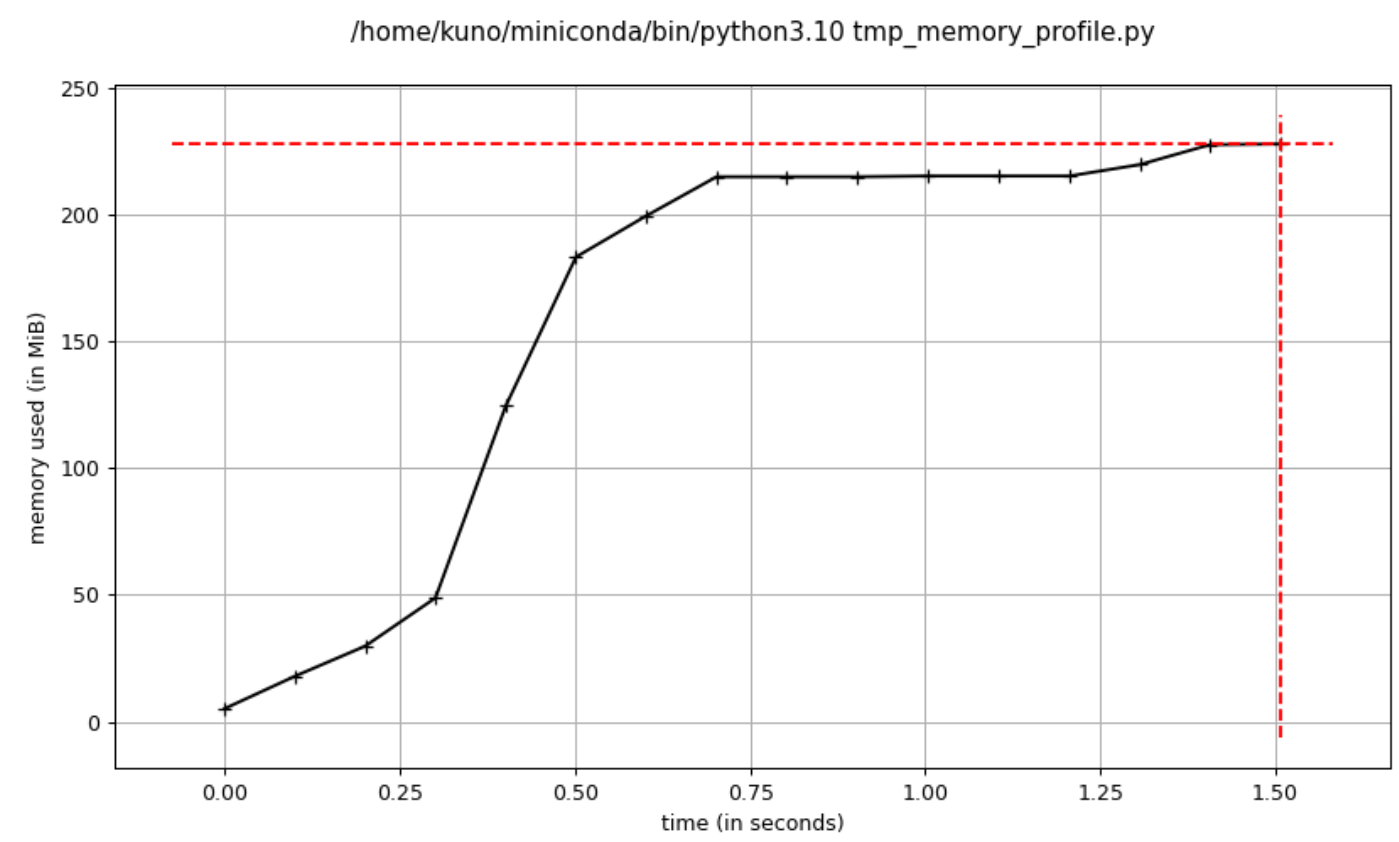

# 👉👉👉 いまここ 👈👈👈

# 👌👌👌 まとめ 👌👌👌


- `extract_mutation_loci`のメモリー使用率を改善しました
    - json形式で中間ファイルを保存し、一行ずつ読み込んで処理する形にしました
- ほぼ`import numpy/scipy`にかかるメモリーだけになりました
- 実行時間はやや伸びてしまいましたが、メモリーエラーになるよりかはマシです
- つぎは`correct_sequence_error`にとりかかります

# 次に取り組むこと

- メモリを節約します
    - ✅ `calc_midsv`
    - ✅ `extract_mutation_loci`
    - ⬜ `correct_sequence_error`
    - ⬜ `classify`
    - ⬜ `clustaring`
    - ⬜ `consensus`
    - ⬜ `report`

### Lists

+ GUIの見栄え
+ igv.jsの起動
+ VCFによる長鎖挿入・欠失情報の付与
+ Figの作成
+ ⬜ Insertionのなかにある変異を同定する手法を考案する
+ ⬜ Ayabe-taks1のright_loxpがいまいちな理由を考察する
+ ✅ 断端リードの扱いをどうするべきか
+ ✅ `SV`の判定をconsensus callのあとにする
+ ✅ Tyrの動作確認
+ ✅ ayabe-task1のleft/right-loxpの検出
+ ✅ mutation_lociをpreprocessで使用したものに変更する
> + ⬜ `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする